In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn import preprocessing

In [2]:
def Normalize(data):
    data = np.asanyarray(data, dtype=np.float64)
    data = (data-data.mean(0)) / data.std(0)
    return data

class Data_split(object):
    def __init__(self, data, cl = None, trainsize = 0.7, shuffle = True, randomstate = None, scaling = True):
        """Split arrays or matrices into random train and test subsets
        
        Parameters
        ----------
        data: data set input
        
        cl: the index of the column including the classes of every record 
            (default = the last column of data)
            
        trainsize: float, int or None, optional (default=0.7)
            If float, should be between 0.0 and 1.0 and represent the proportion 
            of the dataset to include in the test split. If int, represents the
            absolute number of test samples. If None, the value is set to the
            complement of the train size. By default, the value is set to 0.25
            
        shuffle: 
            Whether or not to shuffle the data before splitting.
                    
        """
        np0 = data.shape
        self.n = np0[0]
        self.p = np0[1]
        self.shuffle = shuffle
        self.rs = randomstate
        
        if self.shuffle is True:
            if self.rs is not None: 
                np.random.seed(self.rs)
            self.data = np.random.permutation(data)
        self.cl = self.p-1 if cl is None else cl
        self.X = np.delete(self.data, self.cl, axis=1)
        
        if scaling is True:
            self.X = Normalize(self.X)
        self.Y = self.data[:, self.cl]
        self.trainsize = trainsize
        
    def data_split(self):
        """
        Returns: trainx, trainy, testx, testy
        """
        if type(self.trainsize) == int:
            self.trainsize = self.trainsize
        elif type(self.trainsize)  == float or self.trainsize is None:
            if self.trainsize <0 or self.trainsize>1:
                raise ValueError("The proportion of training data should between 0.0 and 1.0")
            else:
                self.trainsize = int(self.trainsize * self.n)
        self.trainX = self.X[0:self.trainsize, :]
        self.trainY = self.Y[0:self.trainsize]
        self.testX = self.X[self.trainsize:, :]
        self.testY = self.Y[self.trainsize:]
        trainX = self.trainX
        trainY = self.trainY
        testX = self.testX
        testY = self.testY
        return trainX, trainY, testX, testY

In [3]:
def y_t_transfer(data):
    target = np.asanyarray(pd.get_dummies(data, prefix = 'class')*0.6 + 0.2)
    return(target)

class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, trainx, trainy, testx, testy, lr=0.01, epochs=100, ncenter = None, randomstate = 648):
        
#         trainx, trainy, testx, testy = SData.data_split()
        
        self.t = y_t_transfer(trainy)
        self.testt = y_t_transfer(testy)
        
        self.x = trainx
        self.testx = testx
        self.n = trainx.shape[0] # number of samples
        self.ncl = self.t.shape[1] # number of class
        self.lr = lr # learning rate
        self.epochs = epochs
        
        # number of hidden neurons
        if ncenter is None:
            self.ncenter = self.n
        else:
            self.ncenter = ncenter
            np.random.seed(randomstate)
        
        self.center = np.random.permutation(self.x)[0:self.ncenter, :]
        
        # initial weights
        self.wold = 1/self.ncenter * np.ones((self.ncenter, self.ncl))
        self.wnew = 1/self.ncenter * np.ones((self.ncenter, self.ncl))
    
    def fit(self):
        phi = np.ones((self.n, self.ncenter))
        for p in range(self.n):
            for j in range(self.ncenter):
                d = self.x[p, :] - self.center[j, :]
                phi[p, j] = np.exp( - 0.5 * np.dot(d, np.transpose(d)) )
                
        wnew = self.wold
        MSEnew = 1e10
        for e in range(self.epochs):
            Y = np.ones((self.n, self.ncl))
            for p in range(self.n):
                y = np.dot(phi[p, :], wnew)
        #         if math.isinf(y[0]) or math.isinf(y[1]):
        #             print(e,p,phi[p,:])
        #             break
                sigma =  y * (1-y) * (self.t[p,:] - y)
                wold = wnew
                wnew = wold + self.lr * np.dot(phi[p, :].reshape(self.ncenter,1), sigma.reshape(1,self.ncl))
                if np.sum(wnew-wold < 1e-10) > 0.8*self.ncenter*self.ncl:
                    break
            e += 1
            Y = np.dot(phi, wnew)
            MSEold = MSEnew
            MSEnew = (np.sum(np.square(self.t - Y))) / (self.ncl * self.n)
            if MSEold-MSEnew < 1e-5:
                break
        self.wnew = wnew
        return MSEnew
    
    def predict(self):
        n = self.testx.shape[0]
        phi = np.ones((n, self.ncenter))
        for p in range(n):
            for j in range(self.ncenter):
                d = self.testx[p, :] - self.center[j, :]
                phi[p, j] = np.exp( - 0.5 * np.dot(d, np.transpose(d)) )
        Y = np.dot(phi, self.wnew)
        MSE = (np.sum(np.square(self.testt - Y))) / (self.ncl * n)
        return MSE
    
def MSE(SData, ncenter=None):
    trainx, trainy, testx, testy = SData.data_split()
    if ncenter is not None:
        MSE= []
        for i in ncenter:
            nc = i
            rbf = RBFNet(trainx, trainy, testx, testy, ncenter = nc)
            MSE.append( [i, rbf.fit(), rbf.predict()] )
    else:
        rbf = RBFNet(trainx, trainy, testx, testy)
        MSE = [rbf.fit(), rbf.predict()]
    MSE = np.asanyarray(MSE)
    return MSE

For Q3:

Use subsets (include 500 examples) of 3 datasets

In [76]:
Nsub = 500
bank = pd.read_csv('banknote.txt', header = None,
                  names = ['var', 'skew', 'curt', 'entro', 'class'])


For Q4:

Number of centers equal to N

In [94]:
N = np.arange(30,630,30)
N

array([ 30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390,
       420, 450, 480, 510, 540, 570, 600])

## Banknote

In [78]:
bank = pd.read_csv('banknote.txt', header = None,
                  names = ['var', 'skew', 'curt', 'entro', 'class'])
bank.head()

,var,skew,curt,entro,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [79]:
bank = np.asanyarray(bank)
bank.shape

(1372, 5)

In [80]:
np.random.seed(648)
banksub = np.random.permutation(bank)[0:(Nsub-1),:]
bksub = Data_split(banksub, cl=4, randomstate = 648)

In [81]:
%%time
MSE(bksub) # 1st: mse on train; 2nd: mse on test

Wall time: 3.17 s


array([0.06458095, 0.06472959])

In [30]:
bk = Data_split(bank, cl=4, randomstate = 648)
mse = MSE(bk, ncenter = N)

Wall time: 2min 58s


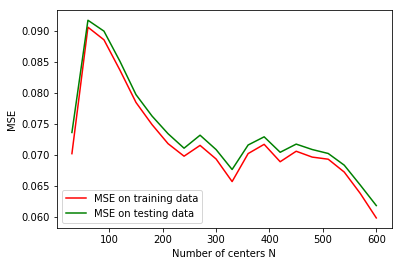

In [82]:
plt.plot(mse[:, 0], mse[:, 1], color='red', label='MSE on training data')
plt.plot(mse[:, 0], mse[:, 2], color = 'green', label = 'MSE on testing data')
# plt.vlines(11, 0, 0.1, colors = "orange", linestyles = "dashed")
plt.xlabel('Number of centers N')
plt.ylabel('MSE')
plt.legend(loc = 3)
plt.show()

## Yeast

In [83]:
yeast = pd.read_csv('yeast.csv', header = None,
                  names = ['name', 'mcg', 'gvh', 'alm', 'mit', 'erl',
                           'pox', 'vac', 'nuc', 'class'])
yeast.head()

,name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [84]:
yst = yeast.drop('name',1)
yst.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [85]:
yst = np.asanyarray(yst)
yst.shape # (1372, 5)

(1484, 9)

In [86]:
np.random.seed(641) # this random seed can not be changed
ystsub = np.random.permutation(yst)[0:(Nsub-1),:]
ytsub = Data_split(ystsub, randomstate = 648)

MSE(ytsub) # 1st: mse on train; 2nd: mse on test

array([0.06034318, 0.05838818])

In [87]:
%%time
yt = Data_split(yst, randomstate = 648)
mse = MSE(yt, ncenter = N)

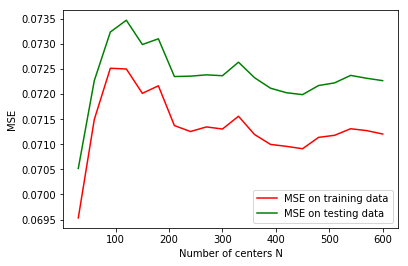

In [91]:
plt.plot(mse[:, 0], mse[:, 1], color='red', label='MSE on training data')
plt.plot(mse[:, 0], mse[:, 2], color = 'green', label = 'MSE on testing data')
# plt.vlines(11, 0, 0.1, colors = "orange", linestyles = "dashed")
plt.xlabel('Number of centers N')
plt.ylabel('MSE')
plt.legend(loc = 4)
plt.show()

# Occupancy

In [4]:
occ = pd.read_csv('occupancy_data.csv', header = None,
                  names = ['temp', 'humid', 'light', 'CO2', 'Ratio', 'class'])
occ.head()

,temp,humid,light,CO2,Ratio,class
0,21.7600,31.133333,437.333333,1029.666667,0.005021,1
1,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2,21.7675,31.122500,434.000000,1003.750000,0.005022,1
3,21.7675,31.122500,439.000000,1009.500000,0.005022,1
4,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [5]:
occ = np.asanyarray(occ)
occ.shape

(9752, 6)

In [6]:
np.random.seed(645)
Nsub = 500
occsub = np.random.permutation(occ)[0:(Nsub-1),:]
osub = Data_split(occsub, cl=5, randomstate = 648)
MSE(osub)

array([0.09531974, 0.0971986 ])

In [7]:
MSE(osub)

array([0.09531974, 0.0971986 ])

In [8]:
%%time
o = Data_split(occ, cl=5, randomstate = 648)
N = np.arange(30,630,30)
mse = MSE(o, ncenter = N)

CPU times: user 6min 6s, sys: 1.85 s, total: 6min 8s
Wall time: 6min 8s


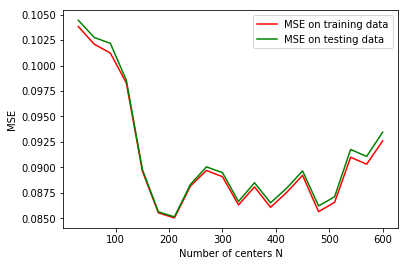

In [12]:
plt.plot(mse[:, 0], mse[:, 1], color='red', label='MSE on training data')
plt.plot(mse[:, 0], mse[:, 2], color = 'green', label = 'MSE on testing data')
# plt.vlines(11, 0, 0.1, colors = "orange", linestyles = "dashed")
plt.xlabel('Number of centers N')
plt.ylabel('MSE')
plt.legend(loc = 1)
plt.show()